# Object splitting for in-silico mixed scRNA-seq data and Slide-Seq data

This example uses TACCO to annotate in-silico mixtures of mouse colon scRNA-seq data and mouse colon slide-Seq data (Avraham-Davidi et al.) and split them into "pure" measurements corresponding to single cell type only.

(Avraham-Davidi et al.): Avraham-Davidi I, Mages S, Klughammer J, et al. Integrative single cell and spatial transcriptomics of colorectal cancer reveals multicellular functional units that support tumor progression. doi: https://doi.org/10.1101/2022.10.02.508492

In [1]:
import os
import sys
import matplotlib

import pandas as pd
import numpy as np
import anndata as ad

import tacco as tc

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

## Load data

In [2]:
reference_data_path = common_code.find_path('results/slideseq_mouse_colon/data')
plot_path = common_code.find_path('results/object_splitting', create_if_not_existent=True)

In [3]:
reference = ad.read(f'{reference_data_path}/scrnaseq.h5ad')
tdata = ad.read(f'{reference_data_path}/slideseq.h5ad')

## Plotting options

In [4]:
highres = False
default_dpi = 100.0
if highres:
    matplotlib.rcParams['figure.dpi'] = 648.0
    hr_ext = '_hd'
else:
    matplotlib.rcParams['figure.dpi'] = default_dpi
    hr_ext = ''

axsize = np.array([3,3])*1.0

labels_colors = pd.Series({'Epi': (0.00784313725490196, 0.24313725490196078, 1.0), 'B': (0.10196078431372549, 0.788235294117647, 0.2196078431372549), 'TNK': (1.0, 0.48627450980392156, 0.0), 'Mono': (0.5490196078431373, 0.03137254901960784, 0.0), 'Mac': (0.9098039215686274, 0.0, 0.043137254901960784), 'Gran': (0.34901960784313724, 0.11764705882352941, 0.44313725490196076), 'Mast': (0.23529411764705882, 0.23529411764705882, 0.23529411764705882), 'Endo': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), 'Fibro': (0.6235294117647059, 0.2823529411764706, 0.0)})

## Define splitting tasks

Generate a reference with balanced type composition, i.e. with the same number of cells for each type

In [5]:
n_labels = reference.obs['labels'].value_counts()
n_labels = n_labels[n_labels>200]
min_n = n_labels.min()
balanced = reference[np.concatenate([ tc.utils.complete_choice(reference.obs.query(f'labels == {label!r}').index, min_n) for label in n_labels.index ])].copy()

Generate in-silico mixtures of scRNA-seq data to benchmark methods with a known ground truth

In [6]:
def mixit(reference,capture_rate):
    tdata = tc.tl.mix_in_silico(reference, type_key='labels', n_samples=len(reference), bead_shape='gauss', bead_size=1.0, capture_rate=capture_rate,)
    tdata.obsm['reads_labels'] /= tdata.obsm['reads_labels'].to_numpy().sum(axis=1)[:,None]
    return tdata

Define the tasks as reference data + mixed data

In [7]:
problems = {
    'balanced reference\n capture_rate=1.0': [balanced,mixit(balanced,capture_rate=1.0),],
    'balanced reference\n capture_rate=0.1': [balanced,mixit(balanced,capture_rate=0.1),],
    ' full reference\ncapture_rate=1.0': [reference,mixit(reference,capture_rate=1.0),],
    ' full reference\ncapture_rate=0.1': [reference,mixit(reference,capture_rate=0.1),],
    'full reference\n  slide_seq': [reference,tdata,],
}

## Create comparison grid

Create grid of plots with tasks in the rows and UMAPs showing different aspects in the columns:
- ground truth mixture annotations (where available)
- TACCO mixture annotation (generated from the mixtures and the reference)
- reference data
- split mixtures

Starting preprocessing
Annotation profiles were not found in `reference.varm["labels"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 0.45 seconds.
Starting annotation of data with shape (1644, 16590) and a reference of shape (1652, 16590) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=labels, normalize_to=adata
   +- multi center: multi_center=10 multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  1.2639881469699417 0.35777931746825187
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 5.97 seconds.
SCumap...SCprep...time 0.8224248886108398
time 26.471531391143

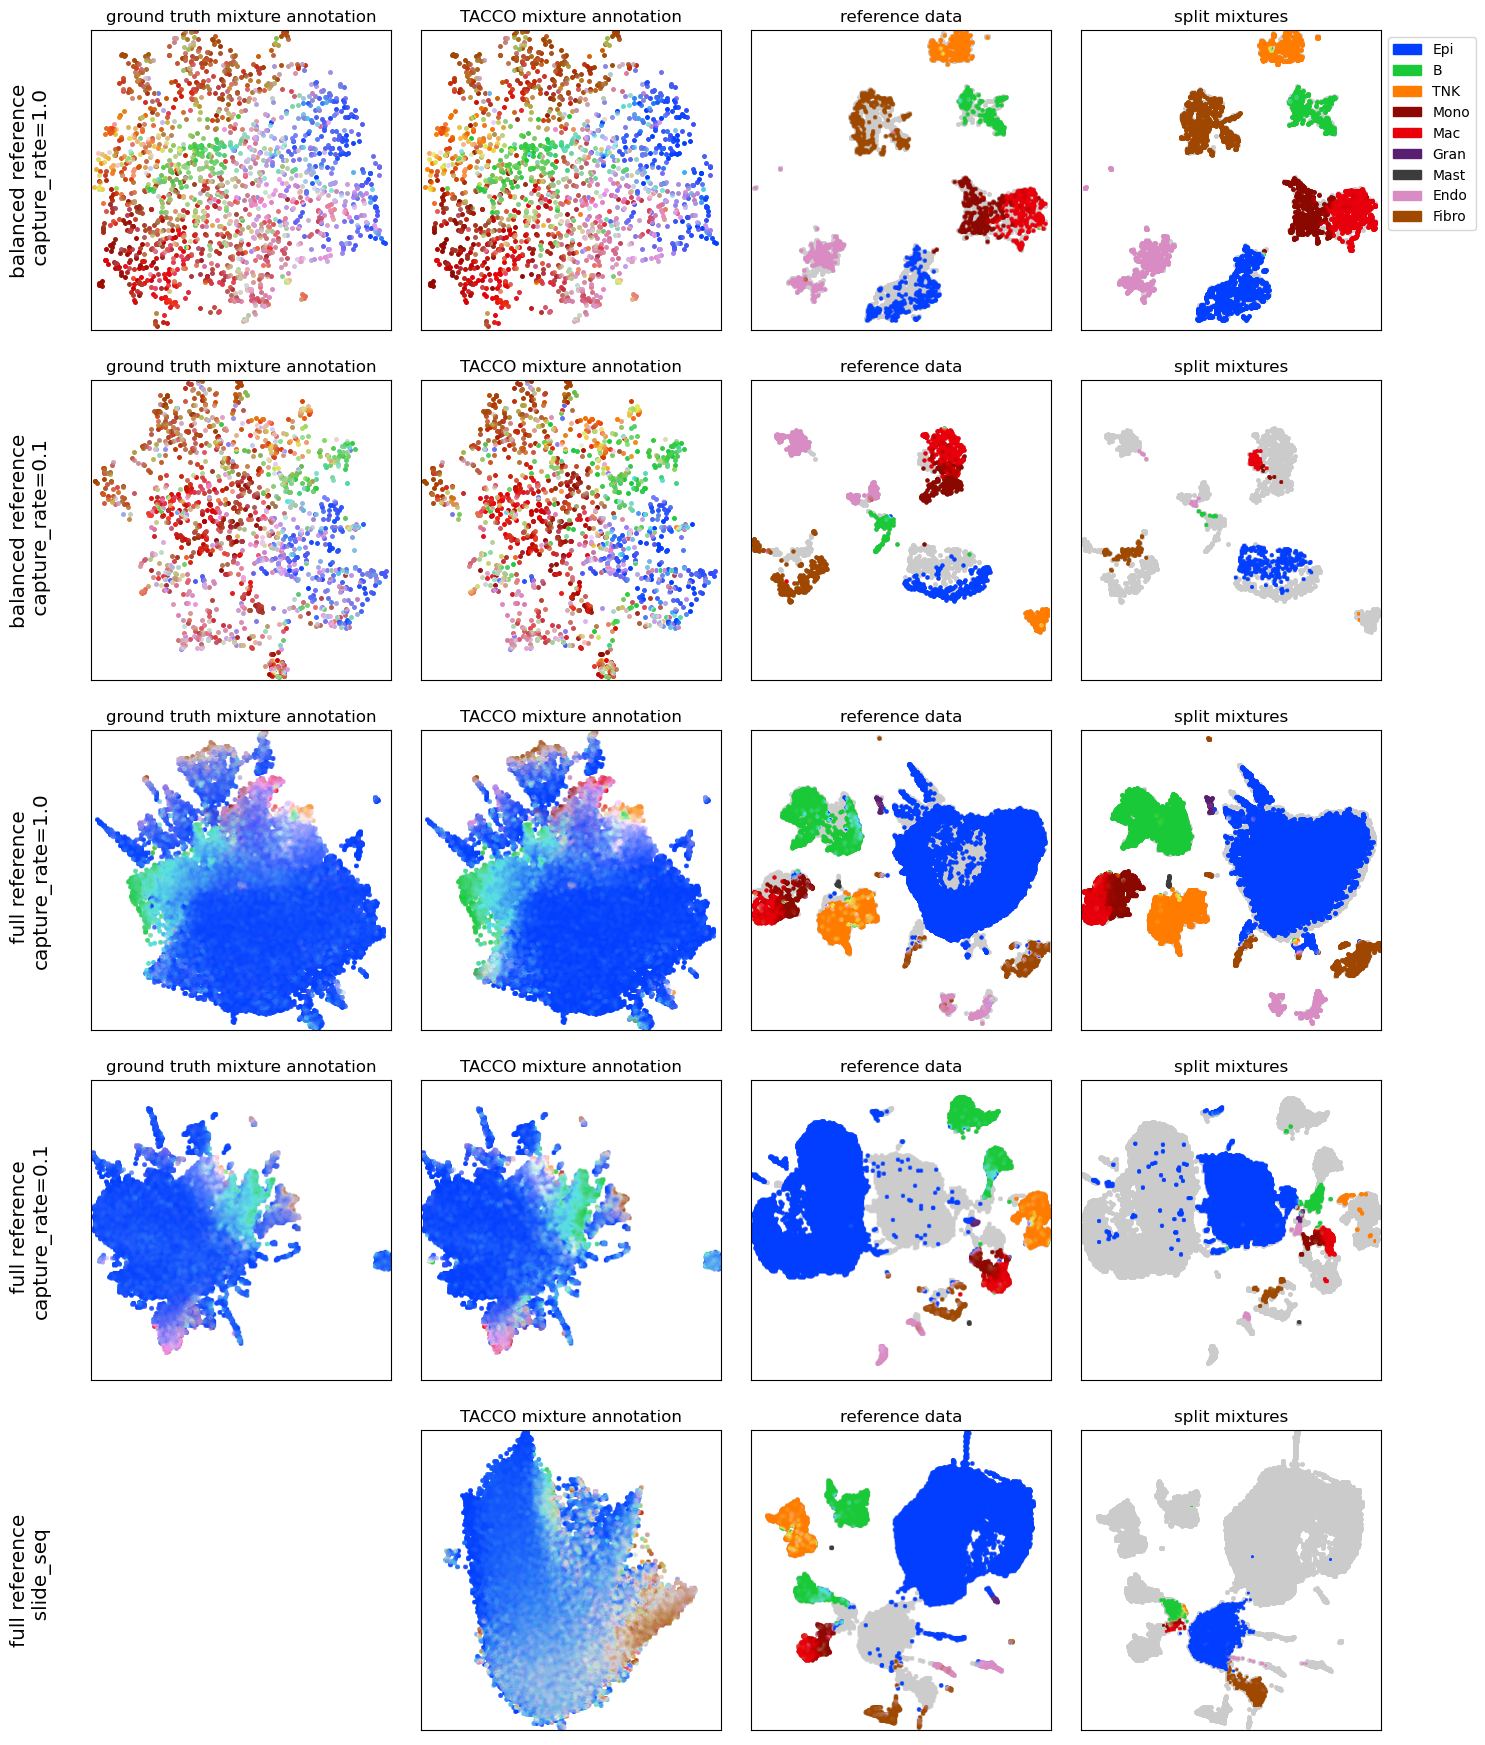

In [8]:
fig,axs=tc.pl.subplots(4,len(problems),x_padding=0.3, y_padding=0.5,axsize=axsize);
for ip, pn in enumerate(problems.keys()):
    ref, adata = problems[pn]
    
    # annotate the mixtures, and keep the extra information for the object splitting
    adata, ref2 = tc.tl.annotate(adata, ref, 'labels', result_key='TACCO', multi_center=10, reconstruction_key='rec', return_reference=True)

    ref2, adata, ref = tc.pp.filter([ref2, adata, ref], return_view=False, )
    
    # UMAP the mixtures
    adata_umap = tc.utils.umap_single_cell_data(adata, hvg=True)
    if 'reads_labels' in adata.obsm:
        tc.pl.scatter(adata_umap, joint=True, position_key='X_umap',ax=axs[ip,0],legend=False, point_size=10, keys='reads_labels', colors=labels_colors, noticks=True);
        axs[ip,0].set_title('ground truth mixture annotation')
    else:
        axs[ip,0].axis('off')
    axs[ip,0].text(-0.2, 0.5, pn, fontsize='x-large', rotation=90, horizontalalignment='center', verticalalignment='center', transform=axs[ip,0].transAxes)
    tc.pl.scatter(adata_umap, joint=True, position_key='X_umap',ax=axs[ip,1],legend=False, point_size=10, keys='TACCO', colors=labels_colors, noticks=True);
    axs[ip,1].set_title('TACCO mixture annotation')

    # split the mixtures
    sdata = tc.tl.split_observations(adata, 'rec', map_obs_keys=True, result_key='labels')

    # jointly preprocess and umap the split mixtures and the reference
    prep_ref = tc.utils.preprocess_single_cell_data(ref, hvg=True)

    ref_hvg = ref[:,sdata.var.index.intersection(prep_ref.var.index)]
    ref_hvg = ref_hvg[tc.sum(ref_hvg.X,axis=1)>=100].copy()
    sdata_hvg = sdata[:,sdata.var.index.intersection(prep_ref.var.index)]
    if pn.endswith('capture_rate=1.0'):
        thr=100
    else:
        thr=30
    sdata_hvg = sdata_hvg[tc.sum(sdata_hvg.X,axis=1)>=thr].copy()
    scat_hvg = ref_hvg.concatenate([sdata_hvg],index_unique=None)
    umap_scat_hvg = tc.utils.umap_single_cell_data(scat_hvg, hvg=False)
    ref_hvg.obsm['X_umap'] = pd.DataFrame(umap_scat_hvg.obsm['X_umap'],index=umap_scat_hvg.obs.index).reindex(ref_hvg.obs.index)
    sdata_hvg.obsm['X_umap'] = pd.DataFrame(umap_scat_hvg.obsm['X_umap'],index=umap_scat_hvg.obs.index).reindex(sdata_hvg.obs.index)

    dummy_key = tc.utils.find_unused_key(umap_scat_hvg.obs)
    umap_scat_hvg.obs[dummy_key] = 'dummy'
    only_gray = {t:'#CCCCCC' for t in umap_scat_hvg.obs[dummy_key].unique()}
    tc.pl.scatter(umap_scat_hvg, joint=True, position_key='X_umap',ax=axs[ip,2], legend=False, point_size=10, keys=dummy_key, colors=only_gray, noticks=True)
    tc.pl.scatter(umap_scat_hvg, joint=True, position_key='X_umap',ax=axs[ip,3], legend=False, point_size=10, keys=dummy_key, colors=only_gray, noticks=True)
    tc.pl.scatter(umap_scat_hvg[ref_hvg.obs.index.intersection(umap_scat_hvg.obs.index)], joint=True, position_key='X_umap',ax=axs[ip,2], legend=False, point_size=8, keys='labels', colors=labels_colors, noticks=True)
    tc.pl.scatter(umap_scat_hvg[sdata_hvg.obs.index.intersection(umap_scat_hvg.obs.index)], joint=True, position_key='X_umap',ax=axs[ip,3], legend=ip==0, point_size=10, keys='labels', colors=labels_colors, noticks=True);
    axs[ip,2].set_title('reference data')
    axs[ip,3].set_title('split mixtures')